# Part 2: Evaluation with CLIP Score and Fréchet Inception Distance (FID)

In this notebook, we will:
1. Calculate the CLIP score for each generated image against its prompt
2. Calculate the FID score comparing generated images to the real TF-Flowers dataset

## Setup for Google Colab

Run this cell first to set up the environment for Google Colab or local execution.

In [ ]:
# Check if running in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
    # Mount Google Drive to access data and save results
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up project directory
    PROJECT_DIR = '/content/drive/MyDrive/ahocv/Lab_3'
    import os
    os.chdir(PROJECT_DIR)
    print(f"Working directory: {PROJECT_DIR}")
else:
    print("Running locally")
    PROJECT_DIR = './'

# Install required packages
%pip install -q open-clip-torch scipy tqdm

🔗 Running in Google Colab!
Mounted at /content/drive
📁 Working directory: /content/drive/MyDrive/ahocv/Lab_3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00


## 2.1 Import Libraries and Load Data from Part 1

In [2]:
import os
import sys
import glob
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from torchvision import transforms, models
from tqdm import tqdm

# Open CLIP for CLIP score calculation
import open_clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load data from Part 1
embeddings_data = np.load('embeddings_data.npy', allow_pickle=True).item()

text_prompts = embeddings_data['prompts']
image_paths = embeddings_data['image_paths']
unet_embeddings = embeddings_data['embeddings']

print(f"Loaded {len(text_prompts)} prompts and {len(image_paths)} image paths")
print(f"Prompts: {text_prompts}")

Loaded 10 prompts and 10 image paths
Prompts: ['A photo of a red rose', 'A photo of a white daisy', 'A photo of a yellow sunflower', 'A beautiful pink rose with green leaves', 'A bright orange sunflower in sunlight', 'A white daisy with yellow center', 'A red rose bud', 'A field of sunflowers', 'A bouquet of daisies', 'A single red rose on a stem']


## 2.2 CLIP Score Calculation

CLIP Score measures the semantic alignment between a text prompt and a generated image. Higher scores indicate better alignment.

In [4]:
# Load OpenCLIP model (using ViT-B-32 as specified in the assignment)
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    'ViT-B-32',
    pretrained='laion2b_s34b_b79k'
)
clip_model = clip_model.to(device)
clip_model.eval()

tokenizer = open_clip.get_tokenizer('ViT-B-32')
print("OpenCLIP model loaded successfully")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

OpenCLIP model loaded successfully


In [5]:
def calculate_clip_score(image_path, text_prompt):
    """
    Calculate the CLIP score between an image and a text prompt.

    Args:
        image_path: Path to the image file
        text_prompt: Text description to compare against

    Returns:
        float: CLIP similarity score (higher is better, range typically 0-1)
    """
    # Preprocess image
    image = clip_preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Tokenize text
    text = tokenizer([text_prompt]).to(device)

    # Compute features and similarity
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)

        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate cosine similarity (dot product of normalized vectors)
        score = (image_features @ text_features.T).item()

    return score

print("CLIP score function defined")

CLIP score function defined


In [6]:
# Calculate CLIP scores for all generated images
clip_scores = []

print("Calculating CLIP scores...")
for img_path, prompt in zip(image_paths, text_prompts):
    score = calculate_clip_score(img_path, prompt)
    clip_scores.append(score)
    print(f"  {prompt}: {score:.4f}")

clip_scores = np.array(clip_scores)
print(f"\nMean CLIP Score: {clip_scores.mean():.4f}")
print(f"Std CLIP Score: {clip_scores.std():.4f}")
print(f"Min CLIP Score: {clip_scores.min():.4f}")
print(f"Max CLIP Score: {clip_scores.max():.4f}")

Calculating CLIP scores...
  A photo of a red rose: 0.2266
  A photo of a white daisy: 0.1856
  A photo of a yellow sunflower: 0.2334
  A beautiful pink rose with green leaves: 0.1647
  A bright orange sunflower in sunlight: 0.1796
  A white daisy with yellow center: 0.1974
  A red rose bud: 0.2567
  A field of sunflowers: 0.1718
  A bouquet of daisies: 0.1357
  A single red rose on a stem: 0.1944

Mean CLIP Score: 0.1946
Std CLIP Score: 0.0340
Min CLIP Score: 0.1357
Max CLIP Score: 0.2567


## 2.3 Fréchet Inception Distance (FID) Calculation

FID measures the distance between the feature distributions of real and generated images. Lower scores indicate that generated images are more similar to real images in terms of quality and diversity.

In [7]:
# Load InceptionV3 model pre-trained on ImageNet
# We use the model up to the final pooling layer to get 2048-dimensional features
inception_model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

# Remove the final classification layer to get features
inception_model.fc = nn.Identity()
inception_model = inception_model.to(device)
inception_model.eval()

print("InceptionV3 model loaded for FID calculation")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:02<00:00, 47.0MB/s]


InceptionV3 model loaded for FID calculation


In [8]:
# InceptionV3 expects 299x299 images
inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_inception_features(image_paths, model, transform):
    """
    Extract InceptionV3 features from a list of images.

    Args:
        image_paths: List of paths to image files
        model: InceptionV3 model
        transform: Image preprocessing transform

    Returns:
        numpy array of shape (N, 2048) containing features
    """
    features = []

    with torch.no_grad():
        for img_path in tqdm(image_paths, desc="Extracting features"):
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)

            # Get features
            feat = model(img_tensor)
            features.append(feat.cpu().numpy().flatten())

    return np.array(features)

print("Feature extraction function defined")

Feature extraction function defined


In [9]:
def calculate_fid(real_embeddings, gen_embeddings):
    """
    Calculate Fréchet Inception Distance between real and generated image distributions.

    Args:
        real_embeddings: numpy array of shape (N, 2048) - features from real images
        gen_embeddings: numpy array of shape (M, 2048) - features from generated images

    Returns:
        float: FID score (lower is better)
    """
    # Calculate mean and covariance for real images
    mu1 = real_embeddings.mean(axis=0)
    sigma1 = np.cov(real_embeddings, rowvar=False)

    # Calculate mean and covariance for generated images
    mu2 = gen_embeddings.mean(axis=0)
    sigma2 = np.cov(gen_embeddings, rowvar=False)

    # Calculate sum of squared differences between means
    ssdiff = np.sum((mu1 - mu2) ** 2)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical errors (imaginary numbers)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Final FID calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

print("FID calculation function defined")

FID calculation function defined


In [ ]:
# Load real flower images from the TF-Flowers dataset
# Dynamic path handling for Colab and local environments
if 'google.colab' in sys.modules:
    DATA_DIR = '/content/drive/MyDrive/ahocv/GenerativeAIWithDiffusionModels/data/cropped_flowers/'
else:
    DATA_DIR = "../GenerativeAIWithDiffusionModels/data/cropped_flowers/"

print(f"Data directory: {DATA_DIR}")

real_image_paths = glob.glob(DATA_DIR + '*/*.jpg', recursive=True)
print(f"Found {len(real_image_paths)} real flower images")

# Limit to a sample for faster computation (you can increase this for more accurate FID)
sample_size = min(500, len(real_image_paths))
np.random.seed(42)
sampled_real_paths = np.random.choice(real_image_paths, sample_size, replace=False).tolist()
print(f"Using {sample_size} real images for FID calculation")

📁 Data directory: /content/drive/MyDrive/ahocv/GenerativeAIWithDiffusionModels/data/cropped_flowers/
Found 1166 real flower images
Using 500 real images for FID calculation


In [11]:
# Extract features from real images
print("Extracting features from real images...")
real_features = get_inception_features(sampled_real_paths, inception_model, inception_transform)
print(f"Real image features shape: {real_features.shape}")

Extracting features from real images...


Extracting features: 100%|██████████| 500/500 [04:33<00:00,  1.83it/s]

Real image features shape: (500, 2048)


In [12]:
# Extract features from generated images
print("Extracting features from generated images...")
gen_features = get_inception_features(image_paths, inception_model, inception_transform)
print(f"Generated image features shape: {gen_features.shape}")

Extracting features from generated images...


Extracting features: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

Generated image features shape: (10, 2048)


In [13]:
# Calculate FID score
fid_score = calculate_fid(real_features, gen_features)
print(f"\nFréchet Inception Distance (FID): {fid_score:.4f}")
print("\nNote: Lower FID is better. Typical values:")
print("  - FID < 50: Excellent quality")
print("  - FID 50-100: Good quality")
print("  - FID > 100: Needs improvement")
print("\n(FID may be high because we only trained for 5 epochs. Train for 100 epochs for better results.)")


Fréchet Inception Distance (FID): 347.7909

Note: Lower FID is better. Typical values:
  - FID < 50: Excellent quality
  - FID 50-100: Good quality
  - FID > 100: Needs improvement

(FID may be high because we only trained for 5 epochs. Train for 100 epochs for better results.)


## 2.4 Visualization of Results

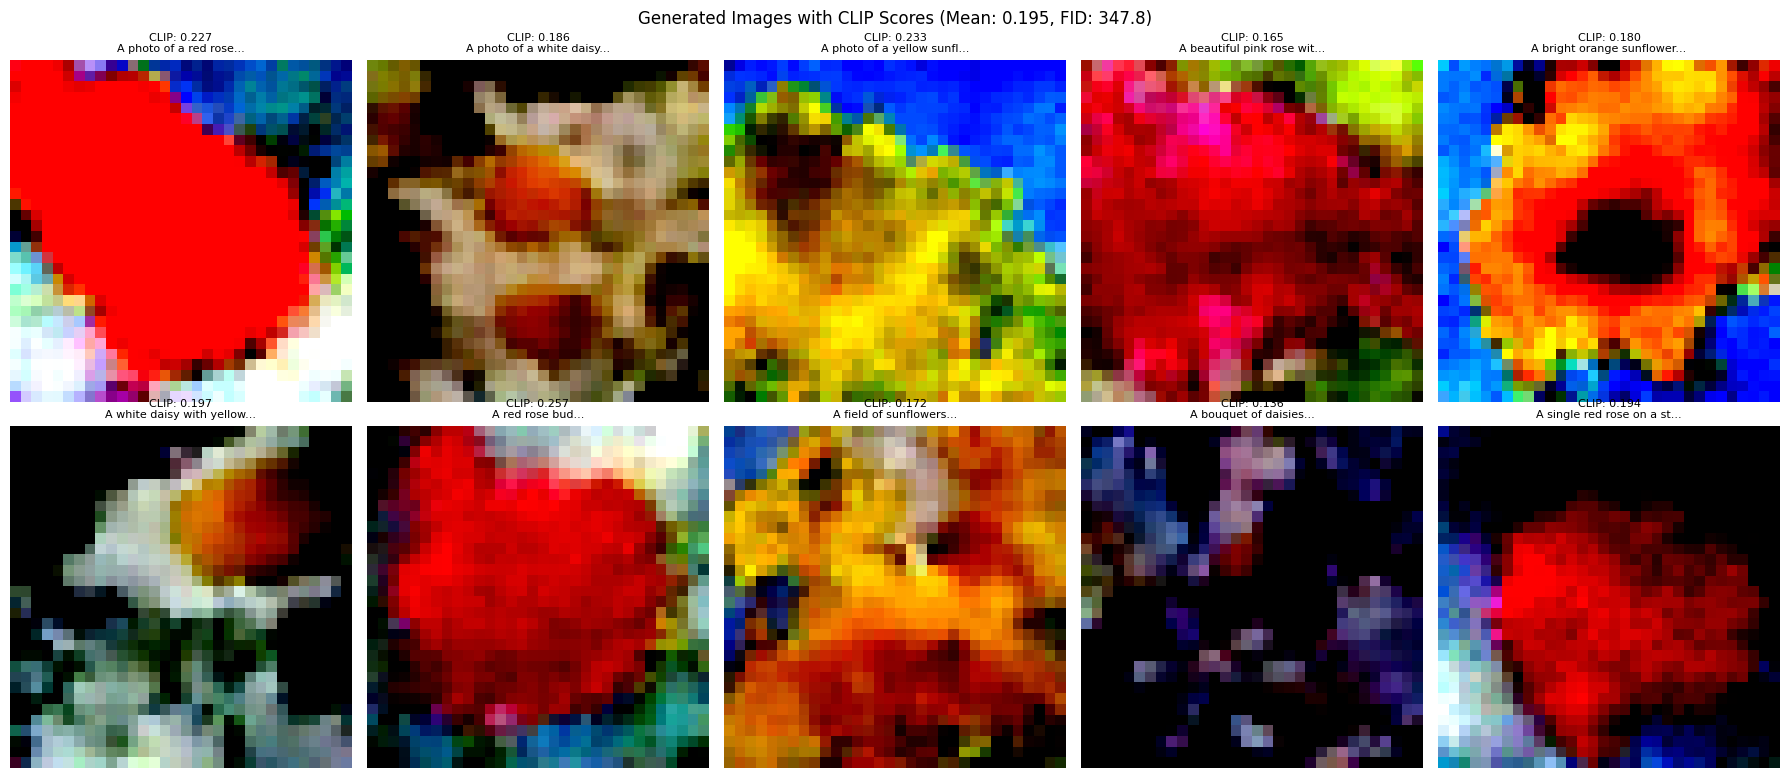

Visualization saved to generated_images/evaluation_results.png


In [14]:
# Ensure output directory exists
os.makedirs("generated_images", exist_ok=True)

# Visualize CLIP scores
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, (img_path, prompt, score) in enumerate(zip(image_paths, text_prompts, clip_scores)):
    ax = axes[idx]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"CLIP: {score:.3f}\n{prompt[:25]}...", fontsize=8)
    ax.axis('off')

plt.suptitle(f"Generated Images with CLIP Scores (Mean: {clip_scores.mean():.3f}, FID: {fid_score:.1f})", fontsize=12)
plt.tight_layout()
plt.savefig("generated_images/evaluation_results.png", dpi=150)
plt.show()

print(f"Visualization saved to generated_images/evaluation_results.png")

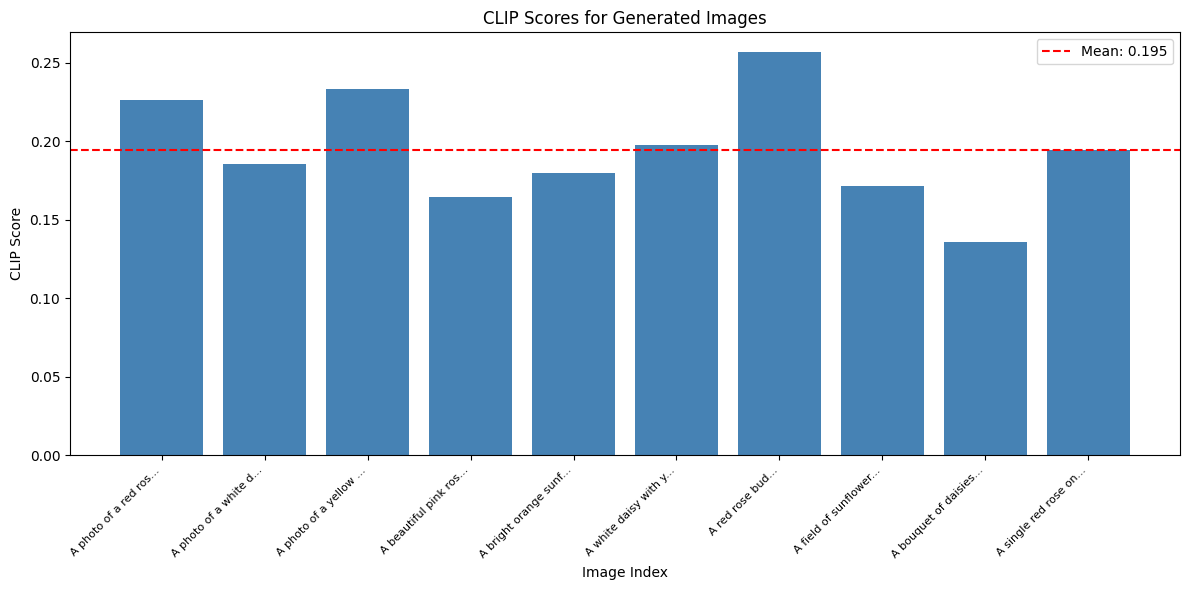

In [15]:
# Create a bar chart of CLIP scores
fig, ax = plt.subplots(figsize=(12, 6))

short_prompts = [p[:20] + "..." for p in text_prompts]
bars = ax.bar(range(len(clip_scores)), clip_scores, color='steelblue')
ax.axhline(y=clip_scores.mean(), color='red', linestyle='--', label=f'Mean: {clip_scores.mean():.3f}')

ax.set_xlabel('Image Index')
ax.set_ylabel('CLIP Score')
ax.set_title('CLIP Scores for Generated Images')
ax.set_xticks(range(len(clip_scores)))
ax.set_xticklabels(short_prompts, rotation=45, ha='right', fontsize=8)
ax.legend()

plt.tight_layout()
plt.savefig("generated_images/clip_scores_chart.png", dpi=150)
plt.show()

## 2.5 Save Evaluation Results for Parts 3 and 4

In [16]:
# Save all evaluation results
evaluation_results = {
    'prompts': text_prompts,
    'image_paths': image_paths,
    'clip_scores': clip_scores,
    'fid_score': fid_score,
    'unet_embeddings': unet_embeddings,
    'inception_features_generated': gen_features,
    'mean_clip_score': float(clip_scores.mean()),
    'std_clip_score': float(clip_scores.std())
}

np.save('evaluation_results.npy', evaluation_results)
print("Evaluation results saved to evaluation_results.npy")

Evaluation results saved to evaluation_results.npy


## 2.6 Summary

This notebook:
1. Set up Google Colab compatibility (auto-mounts Drive)
2. Calculated CLIP scores for text-image alignment
3. Calculated FID score comparing generated vs real images
4. Visualized results with charts and image grids
5. Saved evaluation results for Parts 3 and 4

In [17]:
print("="*60)
print("PART 2 SUMMARY - Evaluation Results")
print("="*60)
print(f"\nCLIP Score (Text-Image Alignment):")
print(f"  Mean: {clip_scores.mean():.4f}")
print(f"  Std:  {clip_scores.std():.4f}")
print(f"  Min:  {clip_scores.min():.4f}")
print(f"  Max:  {clip_scores.max():.4f}")
print(f"\nFréchet Inception Distance (FID):")
print(f"  Score: {fid_score:.4f}")
print(f"\nIndividual CLIP Scores:")
for prompt, score in zip(text_prompts, clip_scores):
    print(f"  {score:.4f} - {prompt}")
print("\nResults saved to: evaluation_results.npy")
print("="*60)

PART 2 SUMMARY - Evaluation Results

CLIP Score (Text-Image Alignment):
  Mean: 0.1946
  Std:  0.0340
  Min:  0.1357
  Max:  0.2567

Fréchet Inception Distance (FID):
  Score: 347.7909

Individual CLIP Scores:
  0.2266 - A photo of a red rose
  0.1856 - A photo of a white daisy
  0.2334 - A photo of a yellow sunflower
  0.1647 - A beautiful pink rose with green leaves
  0.1796 - A bright orange sunflower in sunlight
  0.1974 - A white daisy with yellow center
  0.2567 - A red rose bud
  0.1718 - A field of sunflowers
  0.1357 - A bouquet of daisies
  0.1944 - A single red rose on a stem

Results saved to: evaluation_results.npy
